# SVM to Predict Cardiovascular Disease - Cian Allen

#### Let's first get the necessary imports:

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Now that we've got our imports, let's read our data set. 
##### The dataset is ~70,000 rows of patient information collected at the moment of their medical examination. 
##### It's available on Kaggle and can be found at the following URL: "https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data"
##### I've downloaded the dataset as a CSV file. It is delimited by the ';' character

In [234]:
# Load CSV file into a DataFrame
df = pd.read_csv('cardio_train.csv', sep=';')

### Let's do some basic sanity checks on the data
##### Below I've confirmed that there's no rows that have empty values for any attributes. There appears to be none!
##### I've also removed any duplicated rows. There appears to be 3,821 duplicated rows that we need to drop.

In [235]:
print("Null values for attributes:")
print(df.isnull().sum())
print("\nNumber of duplicated rows to be removed:")
print(df.duplicated().sum())
df = df.drop_duplicates()

Null values for attributes:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Number of duplicated rows to be removed:
0


### Now that we've cleaned our dataset, let's take a look at some details
##### Every row correlates to a patient's medical examination. For every patient, there's 11 different attributes.
##### I've dropped the 'id' column and converted the 'age' information from days to years.

In [236]:
df.drop('id', axis=1, inplace=True)
df['age'] = (df['age'] / 365.25).round().astype(int)

print(df.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   48       1     156    56.0    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


### Now that we've prepared our data, let's take a closer look
##### We'll use plot_column_distribution to visualize the distribution of a specific column

In [237]:
def plot_column_distribution(df, column_name):
    """
    This function calculates the minimum, maximum, and average (mean) of a specified column,
    and then plots a histogram of that column.

    Parameters:
    df (DataFrame): The input dataframe containing the data.
    column_name (str): The column name to analyze and plot (e.g., 'age', 'BMI').
    """
    # Extract the column data
    column_data = df[column_name]

    # Print basic statistics for the column
    print(f'The minimum value in the dataset for {column_name} is {column_data.min().round(2)}')
    print(f'The maximum value in the dataset for {column_name} is {column_data.max().round(2)}')
    print(f'The average (mean) value for {column_name} is {column_data.mean().round(2)}')

    # Plotting the histogram
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.hist(column_data, bins=20, edgecolor='black')  # You can adjust 'bins' for more or fewer bars
    plt.title(f'{column_name} Distribution')  # Title of the graph
    plt.xlabel(column_name)  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label
    plt.show()

##### We can use plot_cardio_vs_column to create a bar graph detailing the presence of cardio disease for each value of a column
##### If our column's values are best placed into bins, we can use plot_cardio_vs_binned_column

In [238]:
def plot_cardio_vs_column(df, column_name):
    """
    Plots the count of cardiovascular disease (cardio) against a specified column.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column_name (str): The column to group by (e.g., 'age').
    """
    # Step 1: Group by the specified column and 'cardio' to get the count of each combination
    grouped = df.groupby([column_name, 'cardio']).size().unstack(fill_value=0)

    # Step 2: Prepare the data for plotting
    column_values = grouped.index.values  # The unique values in the specified column
    counts_0 = grouped[0].values  # Count for cardio = 0
    counts_1 = grouped[1].values  # Count for cardio = 1

    # Step 3: Plot the bar graph
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar width
    width = 0.35

    # Bar positions
    x = np.arange(len(column_values))

    # Plot bars for cardio 0 and 1
    bars_0 = ax.bar(x - width / 2, counts_0, width, label='Disease not present', color='b')
    bars_1 = ax.bar(x + width / 2, counts_1, width, label='Disease present', color='r')

    # Step 4: Customize the plot
    ax.set_xlabel(column_name)
    ax.set_ylabel('Count')
    ax.set_title(f'{column_name} vs Presence of Cardiovascular Disease')
    ax.set_xticks(x)
    ax.set_xticklabels(column_values)
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Step 5: Show the plot
    plt.tight_layout()
    plt.show()

def plot_cardio_vs_binned_column(df, column_name, bins, labels):
    """
    Plots the count of cardiovascular disease (cardio) against a binned column.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column_name (str): The column to create bins for (e.g., 'BMI').
        bins (list): The bin edges for the column.
        labels (list): The labels for the corresponding bins.
    """
    
    # Step 1: Create a new column for binned categories
    df[column_name + '_category'] = pd.cut(df[column_name], bins=bins, labels=labels, right=False)
    
    # Step 2: Group by the new binned category and 'cardio' to get the count of each combination
    grouped = df.groupby([column_name + '_category', 'cardio'], observed=False).size().unstack(fill_value=0)

    # Step 3: Prepare the data for plotting
    categories = grouped.index.values  # The unique categories
    counts_0 = grouped[0].values  # Count for cardio = 0
    counts_1 = grouped[1].values  # Count for cardio = 1

    # Step 4: Plot the bar graph
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar width
    width = 0.35

    # Bar positions
    x = np.arange(len(categories))

    # Plot bars for cardio 0 and 1
    bars_0 = ax.bar(x - width / 2, counts_0, width, label='Disease not present', color='b')
    bars_1 = ax.bar(x + width / 2, counts_1, width, label='Disease present', color='r')

    # Step 5: Customize the plot
    ax.set_xlabel(f'{column_name} Category')
    ax.set_ylabel('Count')
    ax.set_title(f'{column_name} Categories vs Presence of Cardiovascular Disease')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Step 6: Show the plot
    plt.tight_layout()
    plt.show()

##### We can use plot_cardio_ratio to plot the ratio of cardio disease for a column value. 
##### If the column is best when placed into bins, we can use plot_cardio_ratio_vs_binned_columns
##### If the ratio is positive, this means that this column value is more likely to produce cardiovascular disease (vice versa)

In [239]:
def plot_cardio_ratio(df, column_name):
    """
    Plots the ratio of cardiovascular disease present vs disease not present
    based on the given column name for grouping (e.g., 'age', 'gender', etc.).

    Parameters:
    df (DataFrame): The input dataframe containing the data.
    column_name (str): The column name to group by (e.g., 'age', 'gender').
    """
    # Step 1: Group by the specified column and 'cardio' to get the count of each combination
    grouped = df.groupby([column_name, 'cardio']).size().unstack(fill_value=0)

    # Step 2: Prepare the data for plotting
    categories = grouped.index.values  # The unique values in the specified column
    counts_0 = grouped[0].values  # Count for cardio = 0 (no disease)
    counts_1 = grouped[1].values  # Count for cardio = 1 (disease present)

    # Step 3: Calculate the ratio (disease present - disease not present) / disease not present
    # This will result in negative values when there are more people without disease.
    # Avoid division by zero if counts_0 is zero.
    ratio = np.divide(counts_1 - counts_0, counts_0, where=counts_0 != 0)

    # Step 4: Plot the bar chart where positive values go above the x-axis and negative values go below
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar positions
    x = np.arange(len(categories))

    # Assign colors based on the ratio (positive = red, negative = blue)
    colors = ['r' if r > 0 else 'b' for r in ratio]

    # Plot bars for the ratio (positive and negative)
    bars = ax.bar(x, ratio, color=colors)

    # Step 5: Customize the plot
    ax.set_xlabel(column_name)
    ax.set_ylabel('Ratio (Disease Present - Disease Not Present) / Disease Not Present')
    ax.set_title(f'Ratio of Cardiovascular Disease Present vs Disease Not Present by {column_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.axhline(0, color='black', linewidth=1)  # Add a horizontal line at y=0

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Step 6: Show the plot
    plt.tight_layout()
    plt.show()

def plot_cardio_ratio_vs_binned_columns(df, column_name, bins, labels):
    """
    Plots the ratio of cardiovascular disease present vs disease not present
    based on a binned version of the specified column (e.g., 'BMI', etc.).

    Parameters:
    df (DataFrame): The input dataframe containing the data.
    column_name (str): The column name to bin and group by (e.g., 'BMI').
    bins (list): The bin edges for the specified column.
    labels (list): The labels for the bins corresponding to the bin edges.
    """
    # Step 1: Bin the values in the specified column and add them as a new column
    df[column_name + '_binned'] = pd.cut(df[column_name], bins=bins, labels=labels, right=False)

    # Step 2: Group by the binned column and 'cardio' to get the count of each combination
    grouped = df.groupby([column_name + '_binned', 'cardio'], observed=False).size().unstack(fill_value=0)

    # Step 3: Prepare the data for plotting
    categories = grouped.index.values  # The unique binned categories
    counts_0 = grouped[0].values  # Count for cardio = 0 (no disease)
    counts_1 = grouped[1].values  # Count for cardio = 1 (disease present)

    # Step 4: Calculate the ratio (disease present - disease not present) / disease not present
    # This will result in negative values when there are more people without disease.
    # Avoid division by zero if counts_0 is zero.
    ratio = np.divide(counts_1 - counts_0, counts_0, where=counts_0 != 0)

    # Step 5: Plot the bar chart where positive values go above the x-axis and negative values go below
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar positions
    x = np.arange(len(categories))

    # Assign colors based on the ratio (positive = red, negative = blue)
    colors = ['r' if r > 0 else 'b' for r in ratio]

    # Plot bars for the ratio (positive and negative)
    bars = ax.bar(x, ratio, color=colors)

    # We don't need the binned column any more
    df.drop(column_name + '_binned', axis=1, inplace=True)

    # Step 6: Customize the plot
    ax.set_xlabel(f'{column_name} Binned')
    ax.set_ylabel('Ratio (Disease Present - Disease Not Present) / Disease Not Present')
    ax.set_title(f'Ratio of Cardiovascular Disease Present vs Disease Not Present by Binned {column_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.axhline(0, color='black', linewidth=1)  # Add a horizontal line at y=0

    # Step 7: Show the plot
    plt.tight_layout()
    plt.show()

### Now that we've defined our plotting functions, let's do some analysis
##### Starting off with the 'age' column:

The minimum value in the dataset for age is 30
The maximum value in the dataset for age is 65
The average (mean) value for age is 53.3


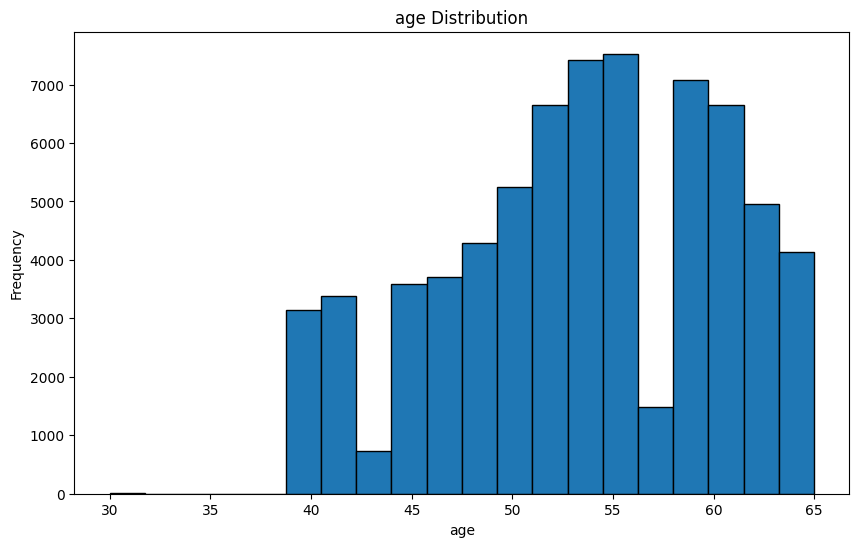

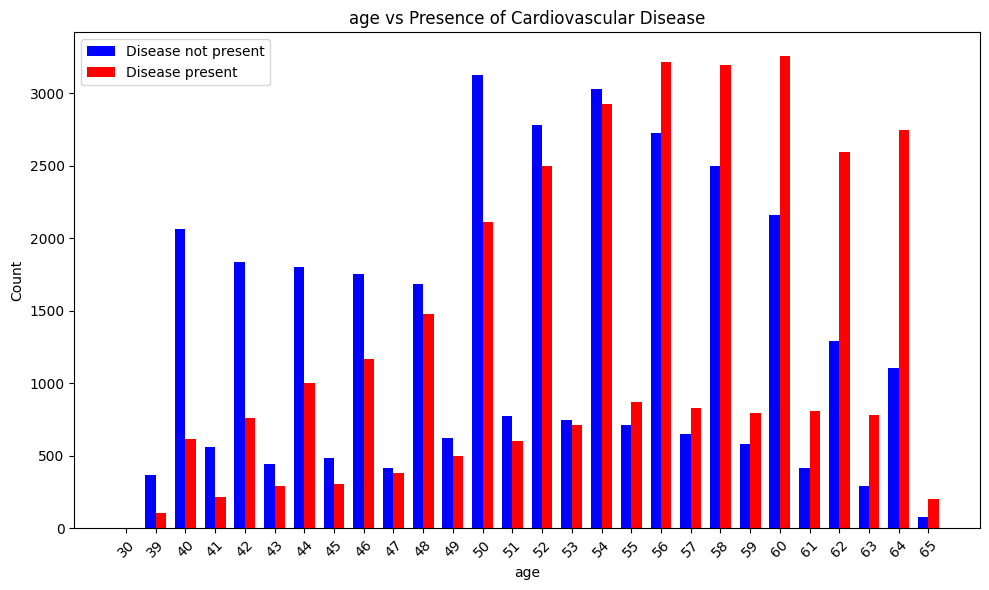

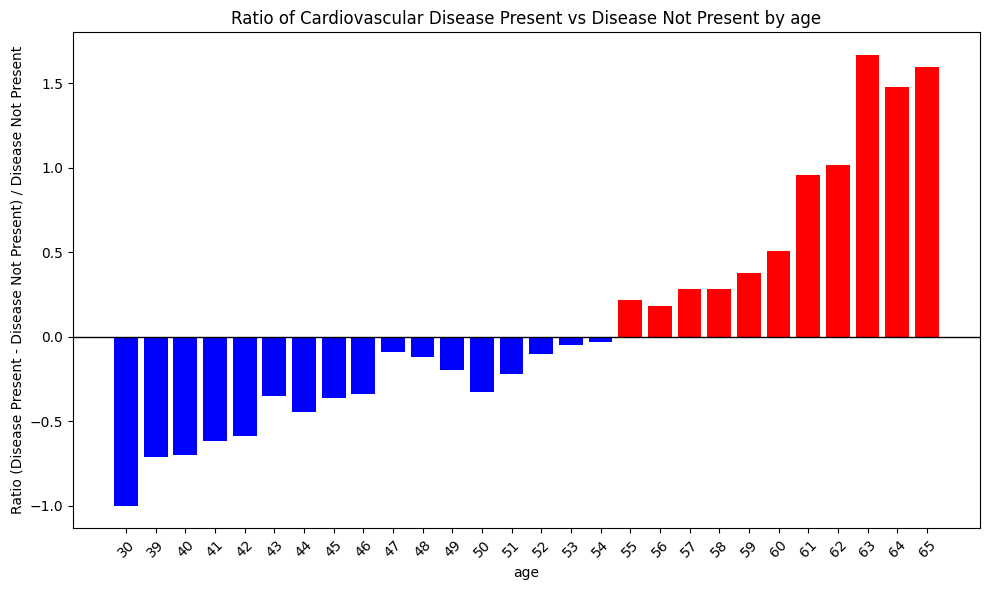

In [240]:
plot_column_distribution(df, 'age')
plot_cardio_vs_column(df, 'age')
plot_cardio_ratio(df, 'age')

##### Let's now create a new column for Body Mass Index. This is the ratio of height to weight and is a general indicator of fitness
###### Note: BMI is a somewhat controversial measurement since it doesn't consider muscle mass 💪

In [241]:
# Define the bins and labels for the column
bmi_bins = [0, 12, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
bmi_labels = ['Severly Underweight', 'Underweight', 'Normal weight', 'Overweight', 'Obesity Class I', 'Obesity Class II', 'Obesity Class III']
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)

##### Let's do some analysis for our new BMI column

The minimum value in the dataset for BMI is 3.47
The maximum value in the dataset for BMI is 298.67
The average (mean) value for BMI is 27.56


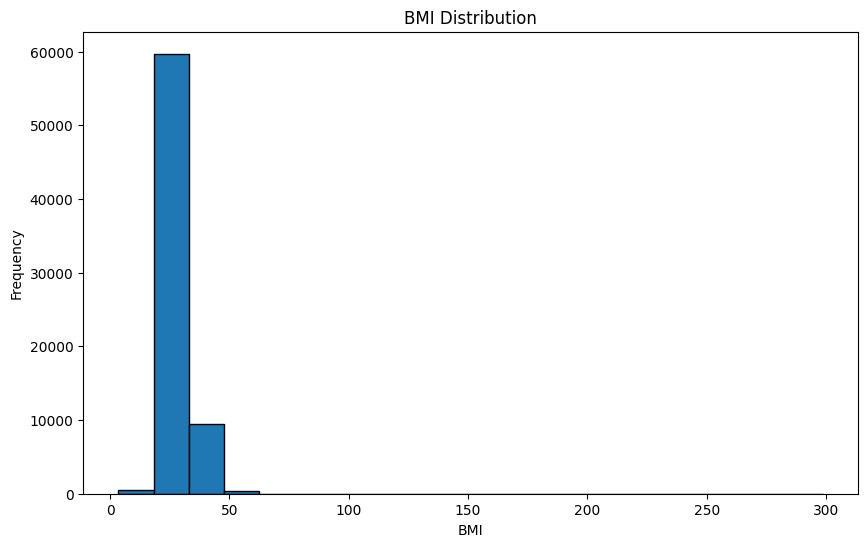

In [242]:
plot_column_distribution(df, 'BMI')

##### Uh oh! This is concerning. It looks like there's a large difference in BMI values and there must be outliers. What's going on?

In [243]:
def print_min_rows_for_column(column_name):
    # Sort the DataFrame by BMI
    sorted = df[column_name].sort_values()

    for i in range (0, 5):
        index = sorted.index[i]
        print(df.loc[index][column_name].round(2))

def print_max_rows_for_column(column_name):
    # Sort the DataFrame by the specified column in descending order
    sorted = df[column_name].sort_values(ascending=False)

    for i in range(0, 5):
        index = sorted.index[i]
        print(df.loc[index][column_name].round(2))

print("Lowest 5 BMIs found in the original dataset:")
print_min_rows_for_column('BMI')
print("\nHighest 5 BMIs found in the original dataset:")
print_max_rows_for_column('BMI')

# A person with severe malnutrition could have a BMI as low as 10 or even lower. We'll use a cutoff of 8
# One of the highest BMIs ever recorded was 105.3. Remove data with BMI higher than this
df = df.drop(df[df['BMI'] < 8].index)
df = df.drop(df[df['BMI'] > 105].index)

print("\nLowest 5 BMIs found in the *adjusted* dataset:")
print_min_rows_for_column('BMI')
print("\nHighest 5 BMIs found in the *adjusted* dataset:")
print_max_rows_for_column('BMI')

Lowest 5 BMIs found in the original dataset:
3.47
3.67
7.02
8.0
9.33

Highest 5 BMIs found in the original dataset:
298.67
278.12
267.77
237.77
191.67

Lowest 5 BMIs found in the *adjusted* dataset:
8.0
9.33
9.92
10.73
11.72

Highest 5 BMIs found in the *adjusted* dataset:
95.22
86.78
86.0
85.78
74.38


##### As described above, there are some big outliers in our BMI data
##### For ex, there's BMI values marked as high as 298. 
##### This kind of BMI has never been recorded in human history. The highest ever recorded BMI was at 105. 
##### BMI's lower than 18 are considered severly underweight. If it's lower than 10, that's considered deathly malnurished. 
##### For our purposes, we've removed instances with BMI higher than 105 and lower than 8.

The minimum value in the dataset for BMI is 8.0
The maximum value in the dataset for BMI is 95.22
The average (mean) value for BMI is 27.5


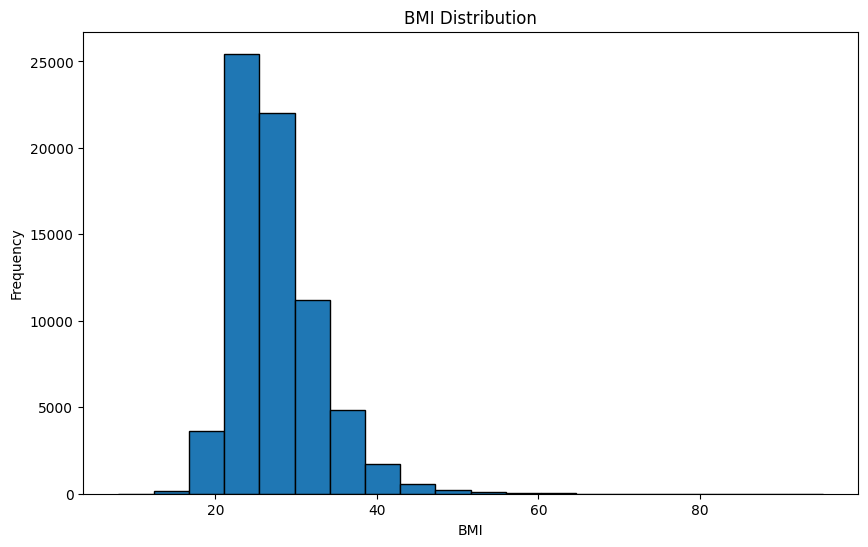

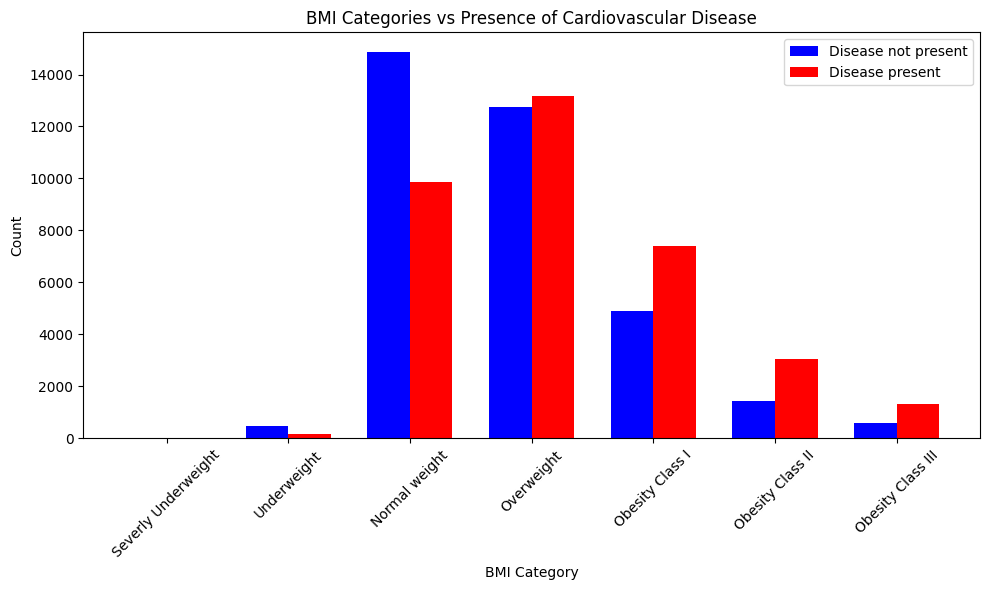

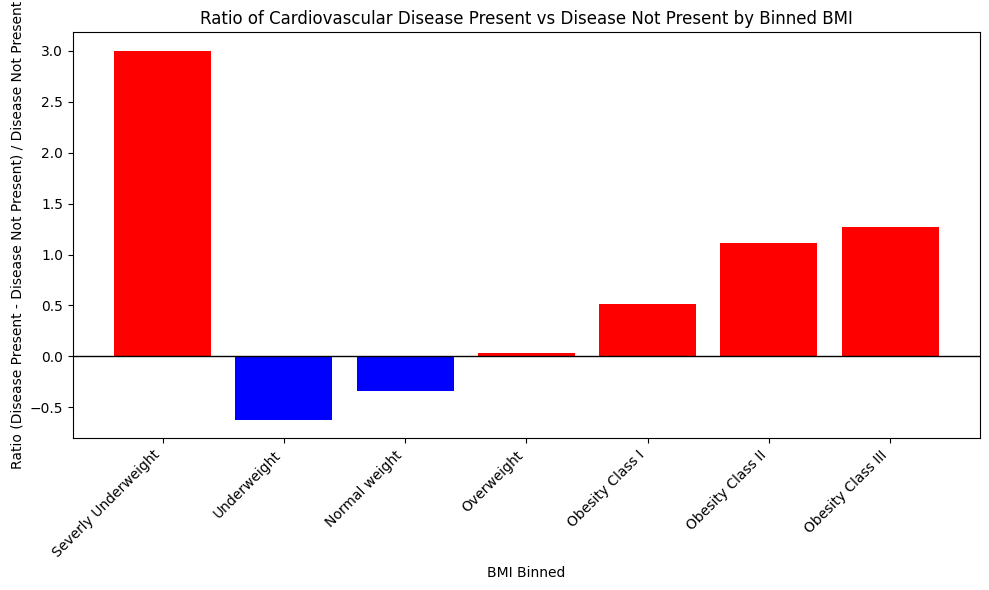

In [244]:
plot_column_distribution(df, 'BMI')
plot_cardio_vs_binned_column(df, 'BMI', bmi_bins, bmi_labels)
plot_cardio_ratio_vs_binned_columns(df, 'BMI', bmi_bins, bmi_labels)

##### Let's plot the ratio for smokers (cigarettes)
##### The value 0 correlates to someone who smokes and 1 is for someone who doesn't smoke

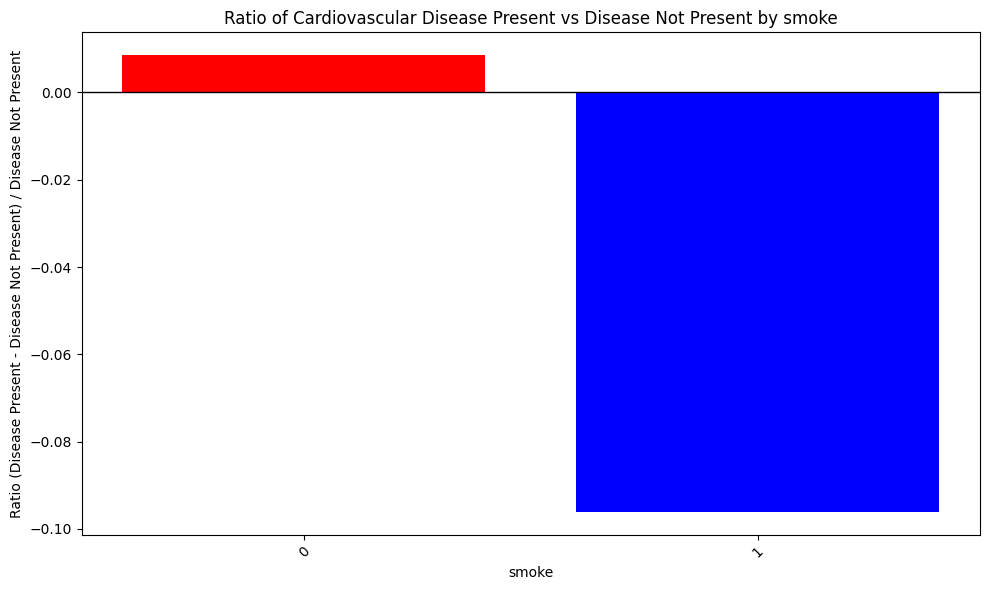

In [245]:
plot_cardio_ratio(df, 'smoke')

##### Let's look at glucose level's impact on cardio disease
##### 1: normal, 2: above normal, 3: well above normal

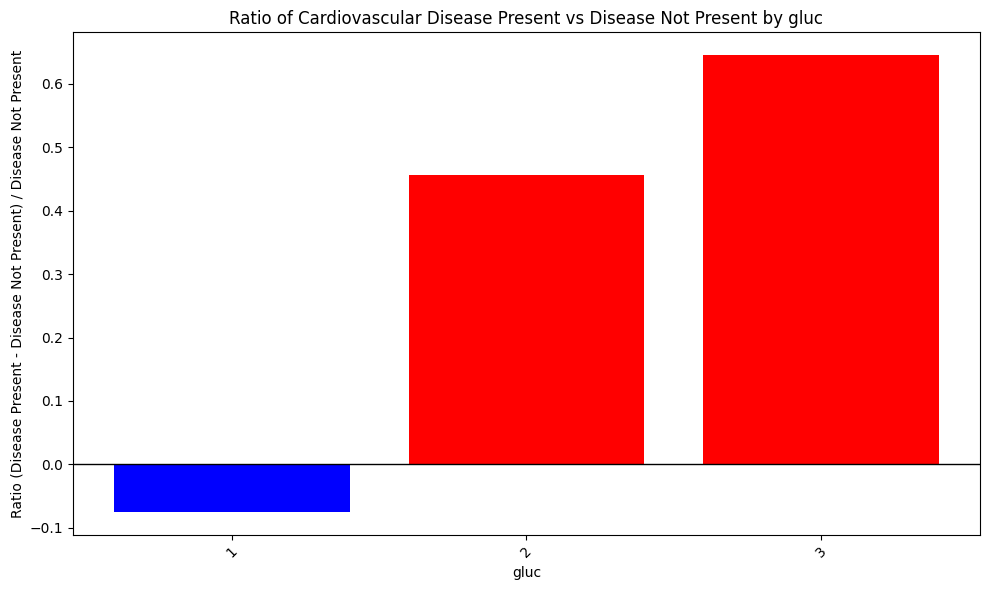

In [246]:
plot_cardio_ratio(df, 'gluc')

##### Let's look at cholesterol level's impact on cardio disease
##### 1: normal, 2: above normal, 3: well above normal

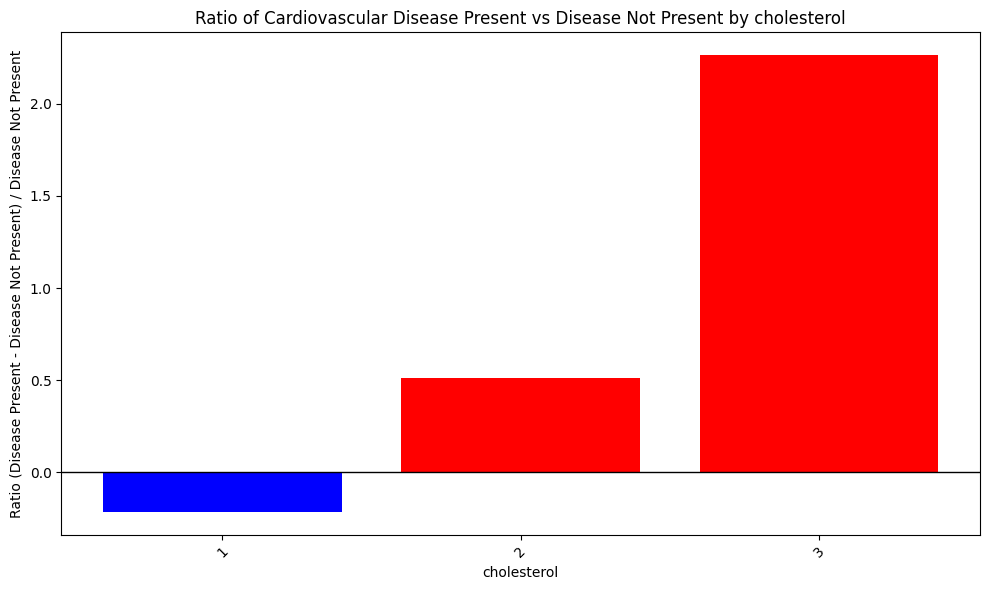

In [247]:
plot_cardio_ratio(df, 'cholesterol')

### Now let's make sure our data is balanced

In [248]:
def balance_data_using_undersampling(df):
    class_dist = df['cardio'].value_counts()
    print("Initial number of instances with cardio disease: %d\nNumber of instances with NO cardio disease: %d" % (class_dist[1], class_dist[0]))

    # Split the dataframe into two classes
    class_1 = df[df['cardio'] == 1]
    class_0 = df[df['cardio'] == 0]

    # Undersample class 0 to match the number of class 1 instances
    class_0_undersampled = resample(class_0, 
                                    replace=False,    # Without replacement
                                    n_samples=len(class_1),  # Match number of samples of class 1
                                    random_state=42)  # For reproducibility

    # Combine the undersampled class 0 with class 1
    df_balanced = pd.concat([class_0_undersampled, class_1])

    # Shuffle the resulting dataframe to mix the classes
    df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    # Now df_balanced is your balanced dataframe
    class_dist = df['cardio'].value_counts()
    print("\nNew number of instances with cardio disease: %d\nNumber of instances with NO cardio disease: %d" % (class_dist[1], class_dist[0]))
    return df
df = balance_data_using_undersampling(df)

Initial number of instances with cardio disease: 34964
Number of instances with NO cardio disease: 35004

New number of instances with cardio disease: 34964
Number of instances with NO cardio disease: 34964


##### As indicated above, there were more instances that had cardio disease
##### To address the imbalance, we can under-sample the majority class to balance our data
##### This effort resulted in a balanced dataset with 34,964 instances of patients with cardio disease and 34,964 without
##### Before we use our model, let's drop the BMI_category column that was created earlier since it was only necessary for visualization our data

In [249]:
# Remove the binned weight column before scaling
df.drop('BMI_category', axis=1, inplace=True)

### Now it's time to build the model!
##### Below is our first model that is built. It an SVM that uses 10-fold cross validation.
##### This first model we've created using the 'linear' kernal method
##### The linear kernal method is best used for data that has a linear relationship

Cross-validation accuracy scores for each fold: [0.72470076 0.71086585 0.72330173 0.72485621 0.71957096 0.71863827
 0.72314628 0.71723924 0.71661744 0.72407897]
Mean accuracy: 0.7203015700295352
Standard deviation of accuracy: 0.00432138355765868


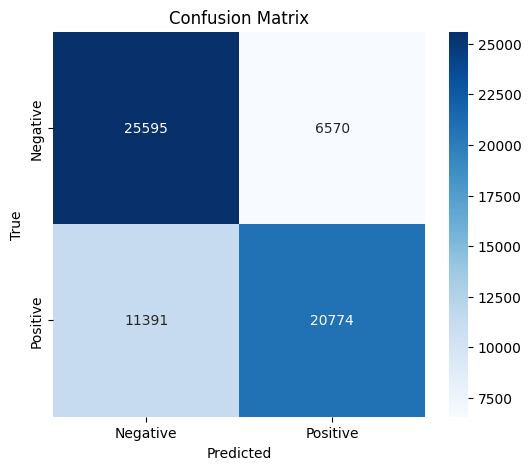

In [ ]:
# Separate features and target variable
X = df.drop(columns='cardio')  # Features: all columns except 'cardio'
y = df['cardio']  # Target: 'cardio' column

# Scale the features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Initialize the SVM model
model = SVC(kernel='linear') 

# Set up 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Perform cross-validation to get accuracy scores
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

# Output the cross-validation results
print(f'Cross-validation accuracy scores for each fold: {scores}')
print(f'Mean accuracy: {np.mean(scores)}')
print(f'Standard deviation of accuracy: {np.std(scores)}')

# Perform cross-validation to get predictions for each fold
predictions = cross_val_predict(model, X_scaled, y, cv=cv)

# Generate the confusion matrix
cm = confusion_matrix(y, predictions)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


##### Now let's try the same model using an 'rbf' kernal method
##### The 'rbf' kernal method is stands for Radial Basis Function
##### This kind of kernal function is best for complex patterns since it can handle both linear and non-linear separations

Cross-validation accuracy scores for each fold: [0.72330173 0.72159179 0.72003731 0.72376807 0.72672159 0.7312296
 0.72423442 0.71444116 0.73014146 0.72563345]
Mean accuracy: 0.7241100575159335
Standard deviation of accuracy: 0.0046196188416933424


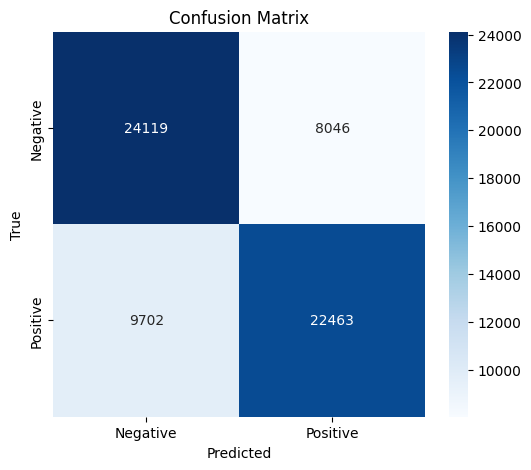

In [78]:
# Separate features and target variable
X = df.drop(columns='cardio')  # Features: all columns except 'cardio'
y = df['cardio']  # Target: 'cardio' column

# Scale the features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Initialize the SVM model
model = SVC(kernel='rbf') 

# Set up 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Perform cross-validation to get accuracy scores
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

# Output the cross-validation results
print(f'Cross-validation accuracy scores for each fold: {scores}')
print(f'Mean accuracy: {np.mean(scores)}')
print(f'Standard deviation of accuracy: {np.std(scores)}')

# Perform cross-validation to get predictions for each fold
predictions = cross_val_predict(model, X_scaled, y, cv=cv)

# Generate the confusion matrix
cm = confusion_matrix(y, predictions)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Finally, let's try the same SVM with kernal mode set to 'poly' and see if it performs any better
##### The 'poly' kernal stands for Polynomial
##### It is often best when there is non-linear decision boundaries

Cross-validation accuracy scores for each fold: [0.68894761 0.6901912  0.69190113 0.69112389 0.68381781 0.69236748
 0.68195243 0.68350692 0.68599409 0.69143479]
Mean accuracy: 0.6881237369811907
Standard deviation of accuracy: 0.0037372669877235596


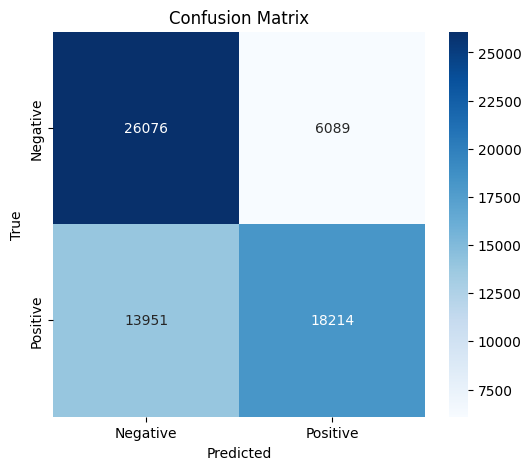

In [79]:
# Separate features and target variable
X = df.drop(columns='cardio')  # Features: all columns except 'cardio'
y = df['cardio']  # Target: 'cardio' column

# Scale the features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scaling the features

# Initialize the SVM model
model = SVC(kernel='poly') 

# Set up 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# Perform cross-validation to get accuracy scores
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

# Output the cross-validation results
print(f'Cross-validation accuracy scores for each fold: {scores}')
print(f'Mean accuracy: {np.mean(scores)}')
print(f'Standard deviation of accuracy: {np.std(scores)}')

# Perform cross-validation to get predictions for each fold
predictions = cross_val_predict(model, X_scaled, y, cv=cv)

# Generate the confusion matrix
cm = confusion_matrix(y, predictions)

# Visualize the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()